<a href="https://colab.research.google.com/github/hanfia-sattar/Neural-Networks/blob/main/Age_Gender_Ethnicity_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Predict age, gender and ethnicity of people using any Pre-trained and UTK Face datasets


https://www.kaggle.com/datasets/jangedoo/utkface-new



In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [ ]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 98% 323M/331M [00:04<00:00, 38.3MB/s]
100% 331M/331M [00:04<00:00, 73.8MB/s]


In [ ]:
!pip install tensorflow==2.13.0
import tensorflow as tf

In [ ]:

import zipfile
zip = zipfile.ZipFile("/content/utkface-new.zip",'r')
zip.extractall("/content")
zip.close()

In [ ]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
folder_path = '/content/UTKFace'

In [ ]:
age = []
gender = []
ethnicity = []
img_path = []

for file in os.listdir(folder_path):
    try:
        parts = file.split("_")
        if len(parts) < 3:
            raise ValueError("File name does not have enough parts")

        a = int(parts[0])
        g = int(parts[1])
        e = int(parts[2])

        # Only append if all conversions are successful
        age.append(a)
        gender.append(g)
        ethnicity.append(e)
        img_path.append(file)
    except (ValueError, IndexError) as e:
        print(f"Skipping file {file} due to error: {str(e)}")

print(f"Length of age: {len(age)}")
print(f"Length of gender: {len(gender)}")
print(f"Length of ethnicity: {len(ethnicity)}")
print(f"Length of img_path: {len(img_path)}")

Skipping file 39_1_20170116174525125.jpg.chip.jpg due to error: invalid literal for int() with base 10: '20170116174525125.jpg.chip.jpg'
Skipping file 61_1_20170109142408075.jpg.chip.jpg due to error: invalid literal for int() with base 10: '20170109142408075.jpg.chip.jpg'
Skipping file 61_1_20170109150557335.jpg.chip.jpg due to error: invalid literal for int() with base 10: '20170109150557335.jpg.chip.jpg'
Length of age: 23705
Length of gender: 23705
Length of ethnicity: 23705
Length of img_path: 23705


In [ ]:
df = pd.DataFrame({'age': age, 'gender': gender, 'ethnicity': ethnicity, 'img': img_path})
df.shape
df.head()

,age,gender,ethnicity,img
0,26,0,1,26_0_1_20170117200408766.jpg.chip.jpg
1,23,1,2,23_1_2_20170116173049386.jpg.chip.jpg
2,68,0,0,68_0_0_20170117172835921.jpg.chip.jpg
3,38,0,0,38_0_0_20170117133757073.jpg.chip.jpg
4,70,0,0,70_0_0_20170104185838254.jpg.chip.jpg


In [ ]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [ ]:
train_df.shape
test_df.shape

(3705, 4)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender','ethnicity'],
                                                    target_size=(128,128),
                                                    class_mode='multi_output')

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender','ethnicity'],
                                                    target_size=(128,128),
                                                  class_mode='multi_output')

Found 20000 validated image filenames.
Found 3705 validated image filenames.


In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras.models import Model

In [ ]:

resnet = ResNet50(include_top=False, input_shape=(128,128,3))

In [ ]:
resnet.trainable=False

output = resnet.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(512, activation='relu')(flatten)
dense2 = Dense(512,activation='relu')(flatten)

dense3 = Dense(512,activation='relu')(dense1)
dense4 = Dense(512,activation='relu')(dense2)

output1 = Dense(1,activation='linear',name='age')(dense3)
output2 = Dense(1,activation='sigmoid',name='gender')(dense4)
output3 = Dense(1,activation='softmax',name='ethnicity')(dense4)

model = Model(inputs=resnet.input,outputs=[output1,output2,output3])

In [ ]:
model.compile(optimizer='adam',
              loss={'age': 'mae',
                    'gender': 'binary_crossentropy',
                    'ethnicity':'categorical_crossentropy'},
              metrics={'age': 'mae',
                       'gender': 'accuracy',
                       'ethnicity':'accuracy'},
              loss_weights={'age':1,
                            'gender':99,
                            'ethnicity':99})


In [ ]:
model.compile(optimizer='adam',loss={'age': 'categorical_crossentropy', 'gender': 'categorical_crossentropy', 'ethnicity': 'categorical_crossentropy'}, metrics={'age': 'accuracy', 'gender': 'accuracy', 'ethnicity': 'accuracy'})


In [ ]:
model.fit(train_generator, batch_size=16, epochs=5, validation_data=test_generator)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


625/625 [==============================] - 2210s 4s/step - loss: 3.9689e-06 - age_loss: 3.9689e-06 - gender_loss: 0.0000e+00 - ethnicity_loss: 0.0000e+00 - age_accuracy: 0.0475 - gender_accuracy: 0.5250 - ethnicity_accuracy: 0.1928 - val_loss: 3.9746e-06 - val_age_loss: 3.9746e-06 - val_gender_loss: 0.0000e+00 - val_ethnicity_loss: 0.0000e+00 - val_age_accuracy: 0.0467 - val_gender_accuracy: 0.5104 - val_ethnicity_accuracy: 0.1808
Epoch 2/5
625/625 [==============================] - 2135s 3s/step - loss: 3.9689e-06 - age_loss: 3.9689e-06 - gender_loss: 0.0000e+00 - ethnicity_loss: 0.0000e+00 - age_accuracy: 0.0475 - gender_accuracy: 0.5250 - ethnicity_accuracy: 0.1928 - val_loss: 3.9746e-06 - val_age_loss: 3.9746e-06 - val_gender_loss: 0.0000e+00 - val_ethnicity_loss: 0.0000e+00 - val_age_accuracy: 0.0467 - val_gender_accuracy: 0.5104 - val_ethnicity_accuracy: 0.1808
Epoch 3/5
625/625 [==============================] - 2157s 3s/step - loss: 3.9689e-06 - age_loss: 3.9689e-06 - gender_lo

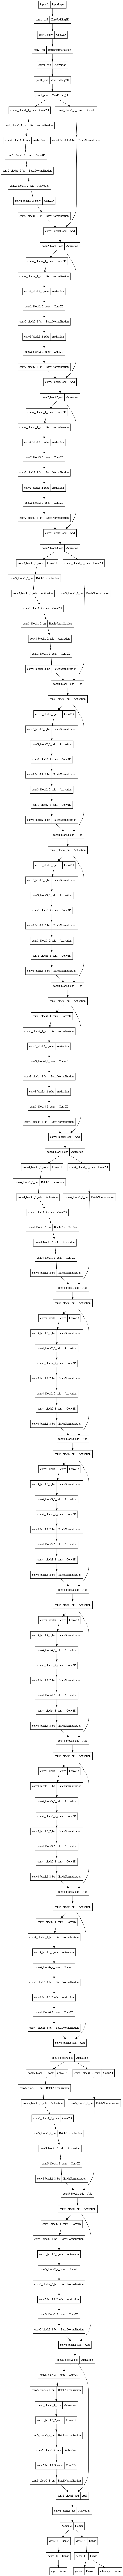

In [ ]:
from keras.utils import plot_model
plot_model(model)

In [ ]:

import cv2
import matplotlib.pyplot as plt

In [ ]:

test_img = cv2.imread('/content/person.jpg')

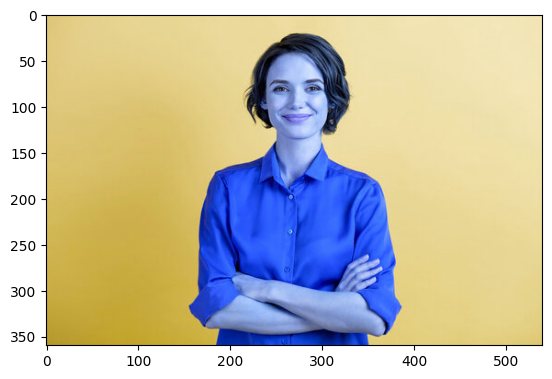

In [ ]:
plt.imshow(test_img)

In [ ]:

test_img.shape

(360, 540, 3)

In [ ]:

test_img = cv2.resize(test_img,(128,128))

In [ ]:
test_input = test_img.reshape((1,128,128,3))

In [ ]:

model.predict(test_input)

1/1 [==============================] - 2s 2s/step


[array([[3.2385778]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32)]

In [ ]:
test_img = cv2.imread('/content/person.jpg')
test_img = cv2.resize(test_img,(128,128))
test_input = test_img.reshape((1,128,128,3))
# Make predictions
predictions = model.predict(test_input)

# Access the predicted age and gender
age = predictions[0][0][0]
gender = predictions[1][0][0]
ethnicity = predictions[2][0][0]

# Print the results
print(f"Predicted age: {age:.2f}")
print(f"Predicted gender: {gender:.2f}")
print(f"Predicted ethnicity: {ethnicity:.2f}")

1/1 [==============================] - 0s 141ms/step
Predicted age: 3.33
Predicted gender: 0.00
Predicted ethnicity: 1.00
